# Thorlabs PDA20H Detector Noise

In this notebook, I characterize the Thorlabs PDA20H detector total noise power vs. integration time to ensure we can meet the signal to noise requirements of the Sapphire window coating transmission measurements.

Sam Condon \
SPHEREx-Test/Cal Laboratory \
Caltech \
05/04/2021

___________________________________________________________________________________________________________________

## Setup

#### Import necessary packages

In [1]:
import pandas as pd
import scipy.fft as spfft
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import date
import u6
import os

#### Define class to run readout via LabJack U6

In [2]:
DETECTOR_PORT = 'AIN0'

class LabJackU6:

    def __init__(self, fs=5e3):
        # Initialize LabJack U6
        self.u6 = u6.U6()
        self.u6.getCalibrationData()
        self.fs = fs
        self.u6.streamConfig(NumChannels=2, ChannelNumbers=[0, 1], ChannelOptions=[0, 0],
                             SettlingFactor=1, ResolutionIndex=1, ScanFrequency=self.fs)

    def integrate(self, integration_time=5.0, avg=True):
        data_dict = {'Detector Voltage': []}
        detector_data = []
        start_time = time.perf_counter()
        self.u6.streamStart()
        for measure in self.u6.streamData():
            # stop condition
            if time.perf_counter() >= (start_time + integration_time):
                break

            if measure is not None and measure['errors'] == 0:
                d = measure[DETECTOR_PORT]
                if avg:
                    detector_data.append(sum(d) / len(d))
                else:
                    detector_data = detector_data + d

        self.u6.streamStop()
        data_dict['Detector Voltage'] = detector_data
        return pd.DataFrame(data_dict)
    
    def stream_stop(self):
        self.u6.streamStop()
    
    def close(self):
        self.u6.close()

#### Define plotting routine

In [3]:
#plot sample time series, histogram, and fourier transform

def plot_time_hist(t, working_samps, title='Sample'):
    fig, plts = plt.subplots(1,2, figsize=(15,5))

    plts[0].plot(t, 1e3*working_samps)
    plts[0].set_title('{} Time Series'.format(title))
    plts[0].set_xlabel('Time (s.)')
    plts[0].set_ylabel('Detector Voltage (mV.)')

    plts[1].hist(1e3*working_samps, bins=10)
    plts[1].set_title('{} Histogram'.format(title))
    plts[1].set_xlabel('Detector Voltage (mV.)')
    plts[1].set_ylabel('Occurences')

#### Define FFT routine

In [4]:
def fft(samples, fs, N=None, scale=None, ax=None, plot=True):
    if N == None:
        N = len(samples)
    if scale is not None:
        samps_fft = scale*spfft.fft(samples, n=N)
    else:
        samps_fft = spfft.fft(samples, n=N)
    freqs = spfft.fftshift(spfft.fftfreq(samples.size, d=1/fs))
    samps_fft = spfft.fftshift(samps_fft)
    samps_fft_mag = np.absolute(samps_fft)
    fft_dict = {'fft': samps_fft, 'fft_mags': samps_fft_mag,
                'freqs': freqs}
    
    
    if ax is None and plot:
        fft_fig, ax = plt.subplots(figsize=(10,5))
    
    if plot:
        ax.plot(fft_dict['freqs'], fft_dict['fft_mags'])
        ax.set_title('Sample FFT')
        ax.set_xlabel('Frequency (Hz.)')

    return fft_dict

#### Define routine to calculate total power in a magnitude spectrum after moving average filtering (i.e. total noise power at a given integration time)

In [5]:
def noise_power_calc(fft_mags, fft_freqs, int_t):
    #Frequency response of moving average filter applied from integration
    Hma = np.abs(np.sinc(fft_freqs*int_t))
    #Apply filtering in fourier space
    fft_mags_integrated = np.multiply(Hma, fft_mags)
    #Convert to two-sided power spectral density
    psd_integrated = (1/4)*(fft_mags_integrated**2)
    
    return np.sum(psd_integrated)

#### Define routine to save csvs and add measurement to log

In [6]:
def save_csv(df):
    count = 0
    date_str = str(date.today())
    int_time_str = str(integration_time)
    fs_str = str(int(fs))
    cnt_str = str(count)
    base_str = 'data\\' + date_str + '_' + int_time_str + '_' + fs_str + '_'
    file_name = base_str + cnt_str + '.csv'
    while os.path.exists(file_name):
        count += 1
        cnt_str = str(count)
        file_name =  base_str + cnt_str + '.csv'
    file_name = file_name
    log_file = open(log_file_name, 'a')
    log_file.write('\n' + file_name)
    df.to_csv(file_name, index=False)

#### Define parameters used to control cells of notebook

In [7]:
log_file_name = 'sample_log.txt'
fs = int(5e3)
sample_time = 100
#lju6 = LabJackU6(fs=fs)

## Sample New Data or Read in Existing

In [ ]:
#Record new data
samples = lju6.integrate(avg=False, integration_time=sample_time)
samps_arr = samples.values.flatten()

samples_nodc = samples - samples.mean()
samps_nodc_arr = samples_nodc.values.flatten()

In [ ]:
save_csv(samples)

In [50]:
#Read existing data
file_name = 'data\\2021-05-11_100_5000_0.csv'
samples_read = pd.read_csv(file_name)
samps_read_arr = samples_read.values.flatten()

samples_read_nodc = samples_read - samples_read.mean()
samps_read_nodc_arr = samples_read_nodc.values.flatten()

## Noise Sample FFT

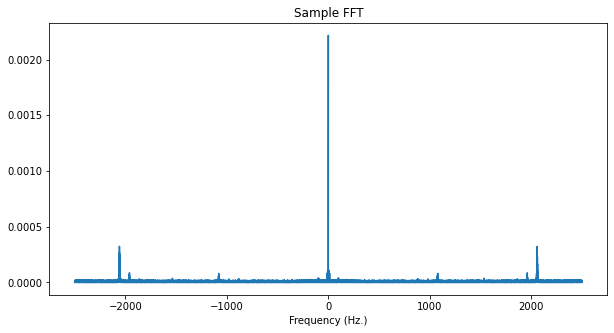

In [56]:
%matplotlib inline
working_samps = samps_read_nodc_arr
ws_len = len(working_samps)
working_samps_fft = fft(working_samps, fs, scale=(2/ws_len)) 


## Noise Power vs. Integration Time

Text(0, 0.5, 'Total noise power')

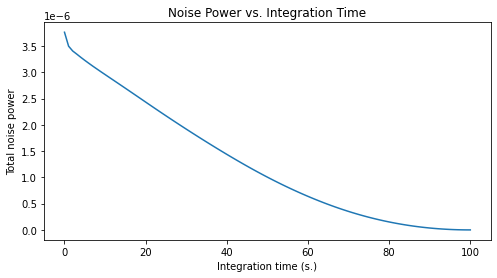

In [57]:
%matplotlib inline
integration_times = np.linspace(0.01, 100, 100)
noise_powers = []
for int_t in integration_times:
    noise_powers.append(noise_power_calc(working_samps_fft['fft_mags'], working_samps_fft['freqs'], int_t))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(integration_times, noise_powers)
ax.set_title('Noise Power vs. Integration Time')
ax.set_xlabel('Integration time (s.)')
ax.set_ylabel('Total noise power')

## Verification

#### Verification of conversion from fft magnitude spectrum to power spectral density

1.511408032492283e-05
1.5114080324922838e-05


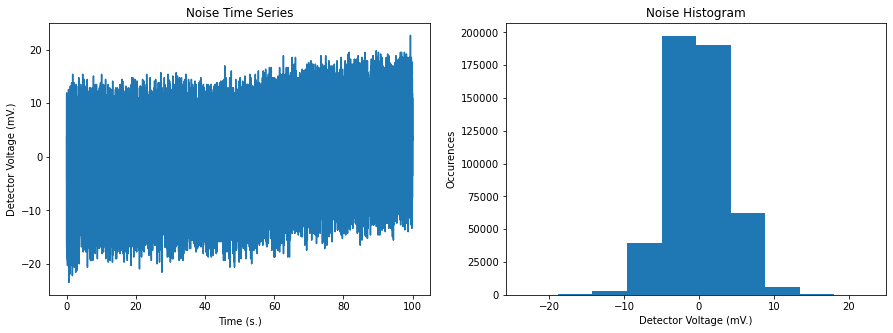

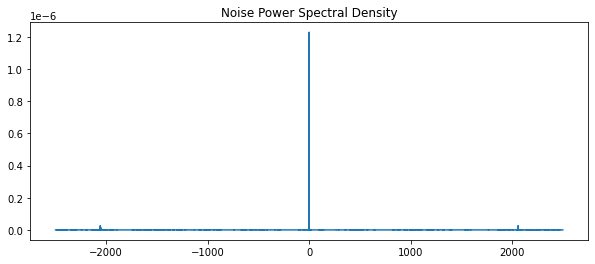

In [58]:
ws_len = len(working_samps)
t = np.arange(0, working_samps.size*(1/fs), (1/fs))
plot_time_hist(t, working_samps, title='Noise')
working_samps_fft = fft(working_samps, fs, scale=(2/ws_len), plot=False)
ws_psd = (1/4)*(working_samps_fft['fft_mags']**2)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(working_samps_fft['freqs'], ws_psd)
ax.set_title('Noise Power Spectral Density')

#Verify total power in time series and power spectral density match
noise_power_time = np.mean(working_samps**2)
noise_power_freq = np.sum(ws_psd)

print(noise_power_time)
print(noise_power_freq)

#### Verification of noise_power_calc routine

In [59]:
int_t = .005

#Generate moving average filter corresponding to given integration time and perform filtering in time
ma_N = int(int_t*fs)
ma_filter = (1/ma_N)*np.ones(ma_N)
ma_filter_fft = fft(ma_filter, fs, N=ws_len, plot=False)
ws_integrated = np.convolve(ma_filter, working_samps)


#Generate sinc function corresponding to frequency response of moving average filter from above
f = working_samps_fft['freqs']
ws_fft_mags = working_samps_fft['fft_mags']
int_sinc = np.abs(np.sinc(f*int_t))
ws_fft_integrated = np.multiply(int_sinc, ws_fft_mags)

#Convert to power spectral density
ws_psd_integrated = (1/4)*(ws_fft_integrated**2)

#Verify that total noise power in time and frequency agree after filtering
integrated_noise_power_time = np.mean(ws_integrated**2)
integrated_noise_power_freq = np.sum(ws_psd_integrated)
test = noise_power_calc(ws_fft_mags, f, int_t)

print(integrated_noise_power_time)
print(integrated_noise_power_freq)
print(test)


3.95710808837229e-06
3.952641127799873e-06
3.952641127799873e-06
